Performance of ideal observer as discussed at SISSA on 06/08/2025

In [107]:
import sys
import os
import numpy as np
import torch
import pandas as pd
import csv
import matplotlib.pyplot as plt
from scipy.stats import binom

In [108]:
# custom imports
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

from src.utils import load_config
import src.graphs_generation as graphs_gen

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Theoretical degree distributions

Functions adapted from:
`\HUPLACLIP-NNs\scripts\visualizations\degree_distribution.ipynb`

In [109]:
def p_correction(p_nodes, graph_size, clique_size):
    '''Returns the value of the corrected p-value in the graph with clique ("p_reduce" case) '''
    p_corrected = (
        p_nodes * graph_size * (graph_size - 1)
        - clique_size * (clique_size - 1)
    ) / ((graph_size - clique_size) * (graph_size + clique_size - 1))
    return p_corrected

# P(d|C=1)
def p_ingroup(degree_arr, graph_size, clique_size, p_corrected):
    ''' 
    For an array of degree values (degree_arr: ndarray of shape [N_graphs, 1, graph_size]), returns the probability that (in a graph WITH the clique) a node INSIDE the clique has exactly that degree.    
    Returns: ndarray of probabilities, same shape as degree_arr
    '''
    return binom.pmf(degree_arr - (clique_size-1),      # number of non-clique connections
                     graph_size - clique_size,  # number of possible non-clique nodes
                     p_corrected
                     )

def p_outgroup(degree_arr, graph_size, clique_size, p_corrected):
    ''' 
    For an array of degree values (degree_arr: ndarray of shape [N_graphs, 1, graph_size]), returns the probability that (in a graph WITH the clique) a node OUTSIDE the clique has exactly that degree.    
    Returns: ndarray of probabilities, same shape as degree_arr
    '''
    return binom.pmf(degree_arr, 
                     graph_size-1, 
                     p_corrected
                     )

def degree_distribution_clique(degree_arr, graph_size, clique_size, p_corrected):
    '''Combines p_outgroup and p_ingroup (single mixture) to obtain the overall probability that (in a graph WITH the clique) a node has exactly that degree'''
    return clique_size/graph_size * p_ingroup(degree_arr, graph_size, clique_size, p_corrected) + (1-clique_size/graph_size) * p_outgroup(degree_arr, graph_size, clique_size, p_corrected)

# P(d|C=0)
def p_noclique(degree_arr, graph_size):
    ''' 
    For an array of degree values (degree_arr: ndarray of shape [N_graphs, 1, graph_size]), returns the probability that (in a graph WITHOUT the clique) a node has exactly that degree.    
    Returns: ndarray of probabilities, same shape as degree_arr
    '''
    return binom.pmf(degree_arr, 
                     graph_size-1, 
                     0.5    # "p_reduce" correction only acts on graph with clique
                     )

def degree_distribution_noclique(degree_arr, graph_size):
    '''
    Uses p_noclique to obtain the overall probability that (in a graph WITHOUT the clique) a node has exactly that degree.
    '''
    return p_noclique(degree_arr, graph_size)

# Ideal observer definition

In [110]:
def ideal_observer(graphs_batch, graph_size, clique_size, p_corrected):
  # for each graph in the batch, compute the degree of each node and store in a 1-D array
  degrees = np.array(torch.sum(graphs_batch, dim=2))  # shape: (batch_size, 1, graph_size)
  # computing degree_distribution_clique for batch:
  decision_variable = np.sum(np.log(degree_distribution_clique(degrees, graph_size, clique_size, p_corrected)) - np.log(degree_distribution_noclique(degrees, graph_size)), 2)  # shape: (batch_size, 1)
  # Convert values > 0 to 1, values <= 0 to 0
  hard_output = (decision_variable > 0).astype(int)
  return hard_output.squeeze()

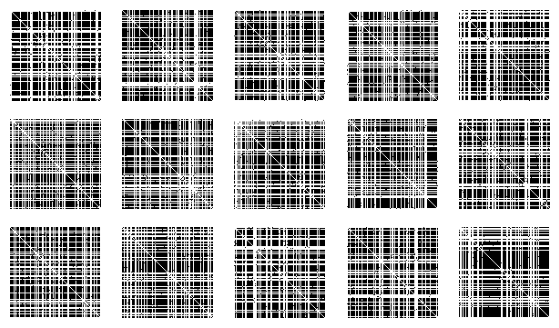

Fraction of correct responses:
1.0


In [111]:
# test of model on a very easy instance:
# visualizing input for graph of 1000 nodes and clique of 300, "p_reduce"
graphs_with_clique = graphs_gen.generate_batch(15, 100, np.repeat([70],15), "p_reduce", False, p_clique=1)
# Show 15 graphs
fig, axes = plt.subplots(3, 5, figsize=(7, 4))
for i in range(15):
    row = i // 5
    col = i % 5
    axes[row, col].imshow(np.squeeze(graphs_with_clique[0][i]), cmap='gray_r')
    axes[row, col].axis('off')
plt.show()
# testing ideal observer on this graph:
p_corrected = p_correction(0.5, 100, 70)
decision_variable = ideal_observer(graphs_with_clique[0], 100, 70, p_corrected)
print("Fraction of correct responses:")
print(np.sum(decision_variable == graphs_with_clique[1]) / 15)

# Test function (adapted)

In [113]:
# TEST FUNCTION
# read configuration file:
config = load_config(
    os.path.join("Ideal-observer_test_config.yml")
)  # CHANGE THIS TO PERFORM DIFFERENT EXPERIMENTS

# looping over the different graph sizes in the experiment:
for graph_size in config["graph_size_values"]:

    # Create empty dictionaries for storing testing results:
    fraction_correct_results = {}  # Fraction correct for each clique size
    metrics_results = {}  # Metrics dictionary

    # Calculate max clique size (proportion of graph size):
    max_clique_size = int(
        config["testing_parameters"]["max_clique_size_proportion_test"] * graph_size
    )

    # Calculate array of clique sizes for all test curriculum
    # NOTE: if max clique size is smaller than the the number of test levels, use max clique size as the number of test levels
    clique_sizes = np.linspace(
        max_clique_size,
        1,
        num=min(max_clique_size, config["testing_parameters"]["clique_testing_levels"]),
    ).astype(int)
    
    # Metrics initialization
    TP, FP, TN, FN = 0, 0, 0, 0  

    # Loop for decreasing clique sizes
    for current_clique_size in clique_sizes:

        # Computing value of p_corrected for current N/K combination
        p_corrected = p_correction(0.5, graph_size, current_clique_size)

        # Initialize fraction correct list, updated at each test iteration
        fraction_correct_list = []

        # Loop for testing iterations:
        for test_iter in range(config["testing_parameters"]["test_iterations"]):

            # Generate clique size value of each graph in the current batch
            clique_size_array_test = graphs_gen.generate_batch_clique_sizes(
                np.array([current_clique_size]),
                config["testing_parameters"]["num_test"],
            )

            # Generate validation graphs
            test = graphs_gen.generate_batch(
                config["testing_parameters"]["num_test"],
                graph_size,
                clique_size_array_test,
                config["p_correction_type"],
                False,
            )
                        
            hard_output = ideal_observer(test[0], graph_size, current_clique_size, p_corrected)
            test_labels = np.array(test[1]) # convert list to numpy array
            # print(hard_output.shape, test_labels.shape)   # DEBUGGING

            # transforming hard_output and test_labels to torch tensors:
            hard_output = torch.tensor(hard_output, dtype=torch.float32)
            test_labels = torch.tensor(test[1], dtype=torch.float32)
            
            # Compute metrics
            TP += ((hard_output == 1) & (test_labels == 1)).sum().item()
            FP += ((hard_output == 1) & (test_labels == 0)).sum().item()
            TN += ((hard_output == 0) & (test_labels == 0)).sum().item()
            FN += ((hard_output == 0) & (test_labels == 1)).sum().item()

            # updating fraction correct list with the accuracy of the current test iteration:
            fraction_correct_list.append(
                (hard_output == test_labels).sum().item()
                / (1.0 * config["testing_parameters"]["num_test"])
            )

        # Updating dictionary after all test iterations for current clique size have been completed:
        fraction_correct_results[current_clique_size] = round(
            sum(fraction_correct_list) / len(fraction_correct_list), 2
        )

        # Printing the size of the clique just tested and the corresponding test accuracy:
        print(
            f"||| Completed testing for clique = {current_clique_size}. "
            f"Average fraction correct = {fraction_correct_results[current_clique_size]}"
        )
        print("|||===========================================================")

    # - notify completion of testing:
    print(f"| Finished testing Ideal observer at N = {graph_size}.")

    # Computing metrics:
    precision = TP / (TP + FP + 1e-10)
    recall = TP / (TP + FN + 1e-10)
    F1 = 2 * (precision * recall) / (precision + recall + 1e-10)
    # AUC - ROC cannot be calculated (no soft outputs)
    # num_params has no meaning
    metrics_results = {
        "TP": TP,
        "FP": FP,
        "TN": TN,
        "FN": FN,
        "precision": precision,
        "recall": recall,
        "F1": F1,
        "AUC_ROC": np.nan,
        "total_params": np.nan,
    }

    # Saving accuracy results in .csv file:
    # - defining file name and path:
    file_path = os.path.join(
        os.getcwd(), "results", f"Ideal-observer_N{graph_size}_fraction_correct.csv"
    )
    # - saving the dictionary as a .csv file:
    with open(file_path, "w") as file:
        writer = csv.writer(file)
        writer.writerow(["clique size", "fraction correct"])  # Add column labels
        for key, value in fraction_correct_results.items():
            writer.writerow([key, value])
    # Saving metrics results in .csv file:
    # - defining file name and path:
    file_path = os.path.join(
        os.getcwd(), "results", f"Ideal-observer_N{graph_size}_metrics.csv"
    )
    # - saving the dictionary as a .csv file:
    pd.DataFrame([metrics_results]).to_csv(file_path, index=False)

    print(f"- Ideal observer Results saved successfully for N = {graph_size}.")

Configuration file loaded successfully.
||| Completed testing for clique = 210. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 207. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 205. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 203. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 201. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 199. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 197. Average fraction correct = 1.0
|||===========================================================
||| Completed testing 

C:\Users\danie\AppData\Local\Temp\ipykernel_5640\690801702.py:5: RuntimeWarning: divide by zero encountered in log
  decision_variable = np.sum(np.log(degree_distribution_clique(degrees, graph_size, clique_size, p_corrected)) - np.log(degree_distribution_noclique(degrees, graph_size)), 2)  # shape: (batch_size, 1)


||| Completed testing for clique = 336. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 332. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 329. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 325. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 322. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 319. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 315. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 312. Average fraction corre